<img src="https://cybersecurity-excellence-awards.com/wp-content/uploads/2017/06/366812.png">

<h1><center>Darwin Supervised Regression Model Building </center></h1>

# Prior to getting started:

Darwin notebook will no longer support 'Register User' starting from 2.0. As a user, you must have credentials ready before using this notebook. 

In order to proceed, in the Environment Variables cell: 
1. Set your username and password to ensure that you're able to log in successfully
2. Set the path to the location of your datasets if you are using your own data.  The path is set for the examples.
3. Set the dataset names accordingly

Here are a few things to be mindful of:
1. For every run, check the job status (i.e. requested, failed, running, completed) and wait for job to complete before proceeding. 
2. If you're not satisfied with your model and think that Darwin can benefit from extra training, use the resume function.

## Import Necessary Libraries

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import numpy as np
from IPython.display import Image
from time import sleep
from sklearn.metrics import r2_score
from amb_sdk.sdk import DarwinSdk

## Set Darwin SDK

In [83]:
ds = DarwinSdk()
ds.set_url('https://darwin-api.sparkcognition.com/v1/')

(True, 'https://amb-api.sparkcognition.com/v1/')

## Environment Variables

In [84]:
#Set your user id and password accordingly
USER="[your Darwin user id]"
PW="[your Darwin password]"

# Set path to datasets - The default below assumes Jupyter was started from amb-sdk/examples/Enterprise/
# Modify accordingly if you wish to use your own data
# PATH_TO_DATASET='../../sets/'
PATH_TO_DATASET='../../sets/'
TRAIN_DATASET='power_train.csv'
TEST_DATASET='power_test.csv'

# A timestamp is used to create a unique name in the event you execute the workflow multiple times or with 
# different datasets.  File names must be unique in Darwin.
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

# User Login 

In [90]:
status, msg = ds.auth_login_user(USER,PW)
if not status:
    print(msg)
else:
    print("Login successfully!")

Login successfully!


# Data Upload

**Read dataset and view a file snippet**

In [91]:
df = pd.read_csv(os.path.join(PATH_TO_DATASET, TRAIN_DATASET))
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [92]:
df.shape

(9001, 5)

**Upload dataset to Darwin**

In [93]:
# Upload dataset
status, dataset = ds.upload_dataset(os.path.join(PATH_TO_DATASET, TRAIN_DATASET))
if not status:
    print(dataset)
else:
    print("Upload dataset successfully!")

Upload dataset successfully!


## Analyze Data
Analyze data is a necessary step before cleaning data and creating model. 

In [94]:
status, analyze_id = ds.analyze_data(TRAIN_DATASET, 
                                     job_name = 'Darwin_analyze_data_job' + "-" + ts, 
                                     artifact_name = 'Darwin_analyze_data_artifact' + "-" + ts)
sleep(1)
if status:
    ds.wait_for_job('Darwin_analyze_data_job' + "-" + ts)
else:
    print(analyze_id)

{'status': 'Complete', 'starttime': '2019-07-19T13:19:22.42972', 'endtime': None, 'percent_complete': 100, 'job_type': 'AnalyzeData', 'loss': None, 'generations': None, 'dataset_names': ['power_train.csv'], 'artifact_names': ['Darwin_analyze_data_artifact-20190719131811'], 'model_name': None, 'job_error': None}


## **Clean dataset**

In [95]:
# clean dataset
target = "PE"
status, job_id = ds.clean_data(TRAIN_DATASET, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Complete', 'starttime': '2019-07-19T13:19:28.321422', 'endtime': None, 'percent_complete': 100, 'job_type': 'CleanData', 'loss': None, 'generations': None, 'dataset_names': ['power_train.csv'], 'artifact_names': None, 'model_name': None, 'job_error': None}


# Create and Train Model 

We will now build a model that will learn the class labels in the target column.<br> In the default boston dataset, the target column is "Assessed_Value". <br> You will have to specify your own target name for your custom dataset. <br> You can also increase max_train_time for longer training.


#### NOTE (New Feature in Darwin 2.0):
User can applies cross-validation in Darwin now. Simply specify k for the number of cross-validaiton to be ran.

In [96]:
cv_kfold = 3

In [97]:
model = target + "_model3" + ts
max_train_time = '00:01'
status, job_id = ds.create_model(dataset_names = TRAIN_DATASET,
                                 model_name =  model,
                                 max_train_time = max_train_time,
                                 fit_profile_name = job_id['profile_name'],
                                 cv_kfold = cv_kfold)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-07-19T13:19:52.110699', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['power_train.csv'], 'artifact_names': None, 'model_name': 'PE_model320190719131811', 'job_error': None}
{'status': 'Running', 'starttime': '2019-07-19T13:19:52.110699', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['power_train.csv'], 'artifact_names': None, 'model_name': 'PE_model320190719131811', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-07-19T13:19:52.110699', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['power_train.csv'], 'artifact_names': None, 'model_name': 'PE_model320190719131811', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-07-19T13:19:52.110699', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'g

In [98]:
ds.lookup_job_status_name(job_id['job_name'])

(True,
 {'status': 'Complete',
  'starttime': '2019-07-19T13:19:52.110699',
  'endtime': '2019-07-19T13:22:29.758398',
  'percent_complete': 100,
  'job_type': 'TrainModel',
  'loss': 0.03736050799489021,
  'generations': 14,
  'dataset_names': ['power_train.csv'],
  'artifact_names': None,
  'model_name': 'PE_model320190719131811',
  'job_error': ''})

# Extra Training (Optional)
Run the following cell for extra training, no need to specify parameters

In [99]:
status, job_id = ds.resume_training_model(dataset_names = TRAIN_DATASET,
                                          model_name = model,
                                          max_train_time = '00:01')
                                          
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-07-19T13:23:43.470222', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.03736050799489021, 'generations': 14, 'dataset_names': ['power_train.csv'], 'artifact_names': None, 'model_name': 'PE_model320190719131811', 'job_error': None}
{'status': 'Running', 'starttime': '2019-07-19T13:23:43.470222', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.03736050799489021, 'generations': 14, 'dataset_names': ['power_train.csv'], 'artifact_names': None, 'model_name': 'PE_model320190719131811', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-07-19T13:23:43.470222', 'endtime': None, 'percent_complete': 16, 'job_type': 'UpdateModel', 'loss': 0.03736050799489021, 'generations': 22, 'dataset_names': ['power_train.csv'], 'artifact_names': None, 'model_name': 'PE_model320190719131811', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-07-19T13:23:43.470222', 'endtime': None, 'percent_comp

# Analyze Model
Analyze model provides feature importance ranked by the model. <br> It indicates a general view of which features pose a bigger impact on the model

In [100]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-07-19T13:26:23.291245', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.03736050799489021, 'generations': 29, 'dataset_names': None, 'artifact_names': ['8d10dfd726854052831d7d4fc98dee74'], 'model_name': 'PE_model320190719131811', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-07-19T13:26:23.291245', 'endtime': '2019-07-19T13:26:24.788321', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.03736050799489021, 'generations': 29, 'dataset_names': None, 'artifact_names': ['8d10dfd726854052831d7d4fc98dee74'], 'model_name': 'PE_model320190719131811', 'job_error': ''}


Show the 10 most important features of the model.

In [101]:
feature_importance[:10]

AT    0.473954
RH    0.212914
AP    0.198111
V     0.115022
dtype: float64

# Predictions
**Perform model prediction on the the training dataset.**

In [102]:
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
df = pd.read_csv(os.path.join(PATH_TO_DATASET, TEST_DATASET))
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2014,12,2,0,15.0,-20,-8.0,1033.0,NW,390.27,0,0
1,2014,12,2,1,11.0,-20,-9.0,1033.0,NW,394.29,0,0
2,2014,12,2,2,13.0,-21,-7.0,1032.0,NE,3.13,0,0
3,2014,12,2,3,11.0,-21,-7.0,1031.0,NE,7.15,0,0
4,2014,12,2,4,13.0,-21,-8.0,1030.0,NE,11.17,0,0


In [103]:
# Upload dataset
status, dataset = ds.upload_dataset(os.path.join(PATH_TO_DATASET, TEST_DATASET))
if not status:
    print(dataset)
else:
    print("Upload successfully!")

Upload successfully!


In [104]:
# clean dataset
status, job_id = ds.clean_data(TEST_DATASET, model_name=model)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

500: INTERNAL SERVER ERROR - {"message": "Internal Server Error"}



In [76]:
status, artifact = ds.run_model(TEST_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-07-19T11:27:14.859754', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.03796868026256561, 'generations': 31, 'dataset_names': ['power_test.csv'], 'artifact_names': ['206daa0a3dad4c5eb167e1276158f938'], 'model_name': 'PE_model320190719111633', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-07-19T11:27:14.859754', 'endtime': '2019-07-19T11:27:17.974223', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.03796868026256561, 'generations': 31, 'dataset_names': ['power_test.csv'], 'artifact_names': ['206daa0a3dad4c5eb167e1276158f938'], 'model_name': 'PE_model320190719111633', 'job_error': ''}


(True, 'Job completed')

Download predictions from Darwin's server.

In [77]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,PE
0,438.742967
1,431.535066
2,483.876969
3,438.310265
4,449.568585


Create plots comparing predictions with actual target

R^2 :  0.9720974229182983


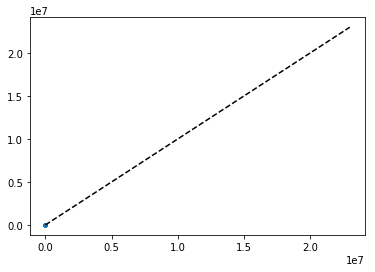

In [78]:
#Plot predictions vs actual
plt.plot(df[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(df[target], prediction[target]))

## Find out which machine learning model did Darwin use:

In [79]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

{'type': 'XGBRegressor', 'parameters': {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.14622890649709844, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 14, 'n_estimators': 231, 'n_jobs': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.6215453923101522}}
